
# Thematische Analyse von Verbraucherbeschwerden mittels NLP

# Einleitung

Das Consumer Financial Protection Bureau (CFPB) sammelt Verbraucherbeschwerden zu Finanzdienstleistungen in den USA.  
Diese Beschwerden liegen als unstrukturierte Texte vor und decken ein breites Spektrum ab – von Kreditkartenproblemen über Hypotheken bis hin zu Betrugsfällen.

Aufgrund der großen Datenmenge ist eine manuelle Analyse ineffizient.  
Ziel dieser Arbeit ist es daher, **Natural Language Processing (NLP)**-Techniken einzusetzen, um die Beschwerdetexte systematisch zu strukturieren und zentrale Themen automatisch zu identifizieren.


# Ziel der Arbeit

Die Analyse soll Entscheidungsträger:innen dabei unterstützen, einen Überblick über häufige und dringende Verbraucherprobleme zu gewinnen.  
Dadurch können Strategien entwickelt werden, um Servicequalität und Verbraucherschutz gezielt zu verbessern.


# Datenquelle

Für die Untersuchung wird der öffentlich verfügbare Datensatz 
**"Consumer Complaints Dataset for NLP"** von Kaggle genutzt:

[ https://www.kaggle.com/datasets/shashwatwork/consume-complaints-datasetfo-nlp](https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp)


Der Datensatz enthält tausende Einträge mit Beschwerdetexten, Produkten, Unternehmen und Zeitangaben.  
Im Fokus stehen hier ausschließlich die textuellen Beschreibungen der Beschwerden.

# 1) Voraussetzungen & Installation

- Es wird empfohlen, eine **virtuelle Umgebung** (`venv`) zu verwenden.  
  Beispiel (Terminal):

  python -m venv .venv
  source .venv/bin/python # unter Linux (WSL2)

- Alle benötigten Abhängigkeiten werden in einer `requirements.txt` abgelegt. 

In [41]:
# Die Datei requirements.txt wird nur erzeugt falls diese nicht existiert.
# Soll die Datei neu erzeugt werden, so muss die bereits vorhande vor dem Ausführen des Codes gelöscht werden. 

if not os.path.exists("requirements.txt"):
    requirements = '''pandas
numpy
scikit-learn
nltk
spacy
gensim
matplotlib
seaborn
wordcloud
tqdm
'''
    with open("requirements.txt", "w") as f:
        f.write(requirements)
    print("✅ requirements.txt erstellt.")
else:
    print("⚠️ requirements.txt existiert bereits. Nichts geändert.")


⚠️ requirements.txt existiert bereits. Nichts geändert.


In [42]:
# Abhängigkeiten importieren

import os
import glob
import pandas as pd

# NLP-Tools
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# Für Sprache Englisch
import spacy
# Dictionaries
from collections import Counter

# ML-Tools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Hinweis:

Falls packages fehlen (ModuleNotFoundError), diese per ".venv/bin/python -m pip install *packagename-1 packagename-2 ... packagename-n*"
installieren. 
Auf diese Weise werden die Pakete in der virtuellen Umgebung für das Projekt installiert (/.venv/lib/python3.11/site-packages/). 

Installiert man die Pakete per "python -m pip install *packagename-1 packagename-2 ... packagename-n*", 
so werden die Pakete **global** im lokalen Benutzerverzeichnis installiert (~/.local/lib/python3.11/site-packages).
Dies kann projektübergreifend zu Problemen führen.

# Installation der benötigten Abhängigkeiten

In das jeweilige Ausführungsverzeichnis wechseln und folgenden Befehl ausführen.

".venv/bin/python -m pip install -r requirements.txt"

# 2) Daten einlesen & Textspalte finden

In [43]:
# Suche nach CSV-Dateien im archive/-Ordner (nach Kaggle-Download)
csvs = glob.glob(os.path.join('archive', '*.csv'))
if not csvs:
    print("Keine CSV-Datei unter archive/ gefunden. Bitte lade den Kaggle-Datensatz herunter und entpacke ihn nach ./archive/")
else:
    print('Gefundene CSV-Dateien:', csvs)
    # Lade die erste CSV (falls mehrere: ggf. anpassen)
    df = pd.read_csv(csvs[0], low_memory=False)
    print('\nSpalten im Datensatz:')
    print(df.columns.tolist())

Gefundene CSV-Dateien: ['archive/complaints_processed.csv']

Spalten im Datensatz:
['Unnamed: 0', 'product', 'narrative']


Textspalte, die **wahrscheinlich** die Beschwerdetexte enthält, wählen.
Nach Spaltennamen, die typische Begriffe wie 'narrative', 'complaint', 'consumer' enthalten, suchen.

In [44]:
# Wenn df existiert: automatisch eine passende Textspalte finden
text_col = None
if 'df' in globals():
    cols = df.columns.tolist()
    candidates = [c for c in cols if ('narrat' in c.lower() or 'complaint' in c.lower() or 'consumer' in c.lower()) and ('narr' in c.lower() or 'text' in c.lower() or 'complaint' in c.lower())]
    if candidates:
        text_col = candidates[0]
        print(f"Automatisch gewählte Textspalte: {text_col}")
    else:
        # Fallback: Versuche einige bekannte Varianten
        for name in ['consumer_complaint_narrative', 'Consumer complaint narrative', 'complaint_what_happened']:
            if name in cols:
                text_col = name
                print(f"Gefundene Textspalte (Fallback): {text_col}")
            break
if text_col is None:
    print('\nKeine eindeutige Textspalte gefunden. Bitte wähle manuell aus der obigen Spaltenliste.')
    # Zeige Beispielinhalte
    if len(cols) > 0:
        print('\nBeispielzeilen (erste 5) jeder Spalte:')
        display(df.head())

Automatisch gewählte Textspalte: narrative


# 3) Datenvorverarbeitung

Da es sich um unstrukturierte Texte handelt, ist eine systematische Bereinigung erforderlich.  
Die wichtigsten Schritte der Textaufbereitung sind:

1. Entfernung von Sonderzeichen, überflüssigen Leerzeichen und Steuerzeichen.
2. Vereinheitlichung der Groß- und Kleinschreibung.
3. Tokenisierung in Wörter oder Subwörter.
4. Entfernung von Stopwords, um irrelevante Begriffe zu reduzieren.
5. Lemmatisierung zur Zusammenführung verschiedener Wortformen.
6. Entfernung von Duplikaten.

Das Ergebnis dieses Prozesses sind **saubere, standardisierte Texte**, die sich für die anschließende numerische und semantische Analyse eignen.

In [45]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

try:
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
except Exception as e:
    print('SpaCy Modell en_core_web_sm nicht gefunden. Bitte ausführen: .venv/bin/python -m spacy download en_core_web_sm')
    raise


# Kombiniere Stopwords (NLTK + spaCy eigene stopwords falls erwünscht)
stop_words = set(stopwords.words('english'))
stop_words |= set(['xxxx', 'xxxxxx']) # Platzhalter: bei Bedarf anpassen

[nltk_data] Downloading package stopwords to /home/ares/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ares/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ares/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
# Flexible Vorverarbeitungsfunktion

def preprocess_text(text, nlp=nlp, stop_words=stop_words, min_token_len=3):
    """Reinigt und lemmatisiert einen Text-String und gibt einen tokenisierten String zurück."""
    if not isinstance(text, str):
        return ''

    # Kleinschreibung, einfache Entfernen von unerwünschten Sequenzen
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'http\S+', ' ', text) # URLs entfernen
    text = re.sub(r'[^a-z\s]', ' ', text) # nur Buchstaben und Leerzeichen
    text = re.sub(r'\s+', ' ', text).strip()
    if not text:
        return ''

    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_space or token.is_punct:
            continue
        lemma = token.lemma_.strip()
        if not lemma:
            continue
        if len(lemma) < min_token_len:
            continue
        if lemma in stop_words:
            continue
        if not lemma.isalpha():
            continue
        tokens.append(lemma)
    return ' '.join(tokens)

In [47]:
# Beispiel: Vorverarbeitung auf eine kleine Auswahl testen (noch nicht auf kompletten Datensatz laufen lassen)
if 'df' in globals() and text_col:
    sample = df[text_col].dropna().astype(str).head(10)
for s in sample:
    print('--- ORIGINAL ---')
    print(s[:200])
    print('\n--- VORVERARBEITET ---')
    print(preprocess_text(s)[:200])
    print('\n')

--- ORIGINAL ---
purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order 

--- VORVERARBEITET ---
purchase order day shipping amount receive product week send followup email exact verbiage pay two day shipping receive order company respond sorry inform due unusually high order volume order ship se


--- ORIGINAL ---
forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secr

--- VORVERARBEITET ---
forward message date tue subject please investigate comenity bank retailer card scam send hello name scamme comenity bank credit card provider company children place new york forever victoria secret o


--- ORIGINAL ---
forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearl

In [48]:
# Vollständige Vorverarbeitung (kann je nach Datensatz lange dauern)
if 'df' in globals() and text_col:
    # Optional: Duplikate entfernen (auf Originaltextspalte)
    df = df.drop_duplicates(subset=[text_col])
    texts = df[text_col].astype(str)
    cleaned = []
    for t in tqdm(texts, desc='Vorverarbeitung'):
        cleaned.append(preprocess_text(t))
    df['cleaned_text'] = cleaned
    print('Vorverarbeitung abgeschlossen. Spalte: cleaned_text')

Vorverarbeitung:   0%|          | 0/124473 [00:00<?, ?it/s]

Vorverarbeitung: 100%|██████████| 124473/124473 [05:20<00:00, 387.81it/s]

Vorverarbeitung abgeschlossen. Spalte: cleaned_text


# 4) Transformation in numerische Vektoren

Zur weiteren Analyse werden die Texte in numerische Repräsentationen überführt.  
Dies ermöglicht den Einsatz von Clustering- und Themenmodellierungsverfahren.

Für diese Arbeit werden zwei Ansätze genutzt:

- **CountVectorizer** – einfache Wortzählung (Bag-of-Words)
- **TF-IDF-Vektorisierung** – gewichtete Repräsentation, die seltene, aber bedeutungsvolle Begriffe hervorhebt


In [49]:
if 'df' in globals() and 'cleaned_text' in df.columns:
    docs = df['cleaned_text'].astype(str).tolist()

    # TF-IDF
    tfidf = TfidfVectorizer(max_df=0.95, min_df=5, max_features=5000, ngram_range=(1,2))
    X_tfidf = tfidf.fit_transform(docs)
    print('TF-IDF Matrix:', X_tfidf.shape)


    # Häufigkeit der einzelnen Tokens (einfaches Counter-Approach auf Token-Strings)
    all_tokens = ' '.join(docs).split()
    freq = Counter(all_tokens)
    print('\nTop 30 Tokens:')
    print(freq.most_common(30))


    # Bigram-Frequenzen mit CountVectorizer
    cv_bigram = CountVectorizer(ngram_range=(2,2), min_df=5)
    X_bigram = cv_bigram.fit_transform(docs)
    sum_words = X_bigram.sum(axis=0)
    bigram_freq = [(word, sum_words[0, idx]) for word, idx in cv_bigram.vocabulary_.items()]
    bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    print('\nTop 20 Bigrams:')
    print(bigram_freq[:20])

TF-IDF Matrix: (124473, 5000)

Top 30 Tokens:
[('account', 252772), ('credit', 242080), ('report', 181304), ('payment', 118240), ('information', 104145), ('call', 103126), ('receive', 81795), ('pay', 81093), ('send', 73789), ('time', 73398), ('would', 73181), ('loan', 70710), ('make', 70482), ('company', 67811), ('card', 66738), ('bank', 65967), ('dispute', 65313), ('get', 64474), ('tell', 64281), ('debt', 62429), ('day', 60967), ('request', 58913), ('say', 57493), ('letter', 56326), ('state', 50539), ('contact', 49726), ('never', 49350), ('charge', 48198), ('date', 48183), ('remove', 47287)]

Top 20 Bigrams:
[('credit report', 70431), ('credit card', 26517), ('credit bureau', 21492), ('credit reporting', 18315), ('identity theft', 16455), ('credit score', 13398), ('make payment', 12516), ('account number', 12261), ('late payment', 12014), ('customer service', 11638), ('reporting agency', 11136), ('fair credit', 9928), ('well fargo', 9905), ('collection agency', 9677), ('report credit'

# 5) Themenmodellierung 

### a) LDA (mit CountVectorizer)

In [50]:
def display_topics(model, feature_names, no_top_words=15):
        topics = []
        for idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append((idx, top_features))
            print(f"\nTopic {idx}:\n", ', '.join(top_features))
        return topics

if 'df' in globals() and 'cleaned_text' in df.columns:
    cv = CountVectorizer(max_df=0.95, min_df=5, max_features=5000)
    dtm = cv.fit_transform(df['cleaned_text'].astype(str))
    n_topics = 8
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
    lda.fit(dtm)

    feature_names = cv.get_feature_names_out()
    topics = display_topics(lda, feature_names, no_top_words=15)


Topic 0:
 loan, mortgage, payment, date, request, receive, home, rate, property, forbearance, amount, document, application, lender, refinance

Topic 1:
 call, tell, receive, send, would, say, letter, ask, get, back, time, pay, company, phone, contact

Topic 2:
 report, credit, account, information, dispute, remove, inquiry, reporting, bureau, open, file, date, consumer, experian, agency

Topic 3:
 payment, credit, pay, late, make, month, time, due, would, score, get, report, year, loan, account

Topic 4:
 claim, court, provide, law, bankruptcy, file, document, contract, report, complaint, consumer, signature, information, debt, state

Topic 5:
 card, get, credit, account, call, money, use, fraud, try, say, one, time, dispute, number, send

Topic 6:
 account, bank, card, check, charge, receive, call, fund, balance, would, close, money, fee, day, make

Topic 7:
 debt, credit, collection, consumer, company, request, provide, report, owe, agency, act, collect, creditor, state, original


### b) NMF (mit TfidfVectorizer)

In [51]:
print("\n--- Themenmodellierung mit NMF (Non-negative Matrix Factorization) ---")
if 'df' in globals() and 'cleaned_text' in df.columns:
    # TF-IDF als Eingabe (besser geeignet für NMF)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=5000)
    tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

    n_topics = 8
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(tfidf)

    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

    # Zeige Top-Wörter für NMF
    nmf_topics = display_topics(nmf, feature_names_tfidf, no_top_words=15)


--- Themenmodellierung mit NMF (Non-negative Matrix Factorization) ---

Topic 0:
 report, credit, remove, bureau, information, score, inaccurate, reporting, item, experian, please, equifax, show, late, transunion

Topic 1:
 payment, late, loan, pay, mortgage, make, month, due, interest, balance, fee, time, would, amount, forbearance

Topic 2:
 debt, collection, owe, company, agency, collect, pay, validation, original, creditor, bill, collector, allege, amount, contract

Topic 3:
 account, open, balance, close, fraudulent, remove, charge, bank, number, acct, date, collection, belong, mine, pnc

Topic 4:
 inquiry, hard, authorize, credit, unauthorized, date, add, company, remove, per, authorization, initiate, permissible, follow, knowledge

Topic 5:
 call, card, bank, tell, get, say, money, would, check, back, charge, time, receive, phone, one

Topic 6:
 identity, theft, fraudulent, victim, block, act, open, information, fair, name, police, report, possible, formal, ftc

Topic 7:
 dispu

### c) Vergleich LDA vs. NMF - Kohärenzbewertung & Analyse

In [52]:
print("\n--- Vergleich von LDA und NMF: Modellgüte ---")

# Vorbereitung für Gensim-Coherence-Berechnung
texts_tokenized = [t.split() for t in df['cleaned_text']]
id2word = corpora.Dictionary(texts_tokenized)
corpus = [id2word.doc2bow(text) for text in texts_tokenized]

# Gensim-LDA (zur Kohärenzbewertung, nicht identisch mit sklearn-LDA)
lda_gensim = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=n_topics,
    random_state=42,
    passes=5,
    chunksize=1000,
    update_every=1,
    alpha='auto',
    per_word_topics=True
)

# Kohärenz für LDA
coherence_lda = CoherenceModel(model=lda_gensim, texts=texts_tokenized, dictionary=id2word, coherence='c_v')
coh_lda = coherence_lda.get_coherence()

# Kohärenz für NMF (Gensim erwartet ebenfalls Topics als Listen)
nmf_topic_words = [topic[1] for topic in nmf_topics]
coherence_nmf = CoherenceModel(topics=nmf_topic_words, texts=texts_tokenized, dictionary=id2word, coherence='c_v')
coh_nmf = coherence_nmf.get_coherence()

print(f"\nCoherence Score LDA  : {coh_lda:.4f}")
print(f"Coherence Score NMF  : {coh_nmf:.4f}")


--- Vergleich von LDA und NMF: Modellgüte ---

Coherence Score LDA  : 0.5090
Coherence Score NMF  : 0.5196


### d) Gegenüberstellung der Ergebnisse


--- Vergleich LDA vs. NMF ---


,Modell,Algorithmus,Eingabematrix,Kohärenz (c_v),Interpretation
0,LDA,Latent Dirichlet Allocation,CountVectorizer,0.508990,"breite, überlappende Themen – gut für explorat..."
1,NMF,Non-negative Matrix Factorization,TF-IDF,0.519595,schärfer getrennte Themen – gut für klare Kate...


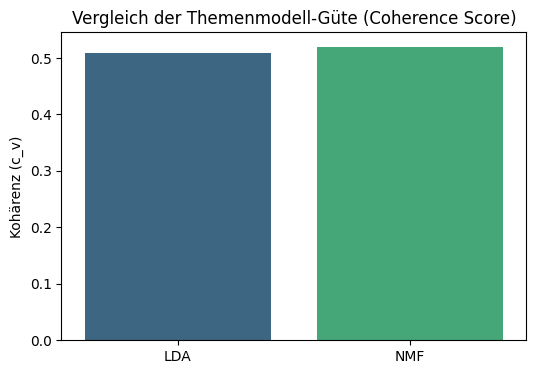

In [60]:
comparison_df = pd.DataFrame({
    'Modell': ['LDA', 'NMF'],
    'Algorithmus': ['Latent Dirichlet Allocation', 'Non-negative Matrix Factorization'],
    'Eingabematrix': ['CountVectorizer', 'TF-IDF'],
    'Kohärenz (c_v)': [coh_lda, coh_nmf],
    'Interpretation': [
        'breite, überlappende Themen – gut für explorative Analysen',
        'schärfer getrennte Themen – gut für klare Kategorisierung'
    ]
})

print("\n--- Vergleich LDA vs. NMF ---")
display(comparison_df)

# Optional: visuelle Gegenüberstellung der Kohärenzwerte
plt.figure(figsize=(6,4))
sns.barplot(x='Modell', y='Kohärenz (c_v)', data=comparison_df, hue='Modell', dodge=False, legend=False, palette='viridis')
plt.title('Vergleich der Themenmodell-Güte (Coherence Score)')
plt.ylabel('Kohärenz (c_v)')
plt.xlabel('')
plt.show()

# 6) Visualisierung der Top-Wörter pro Thema

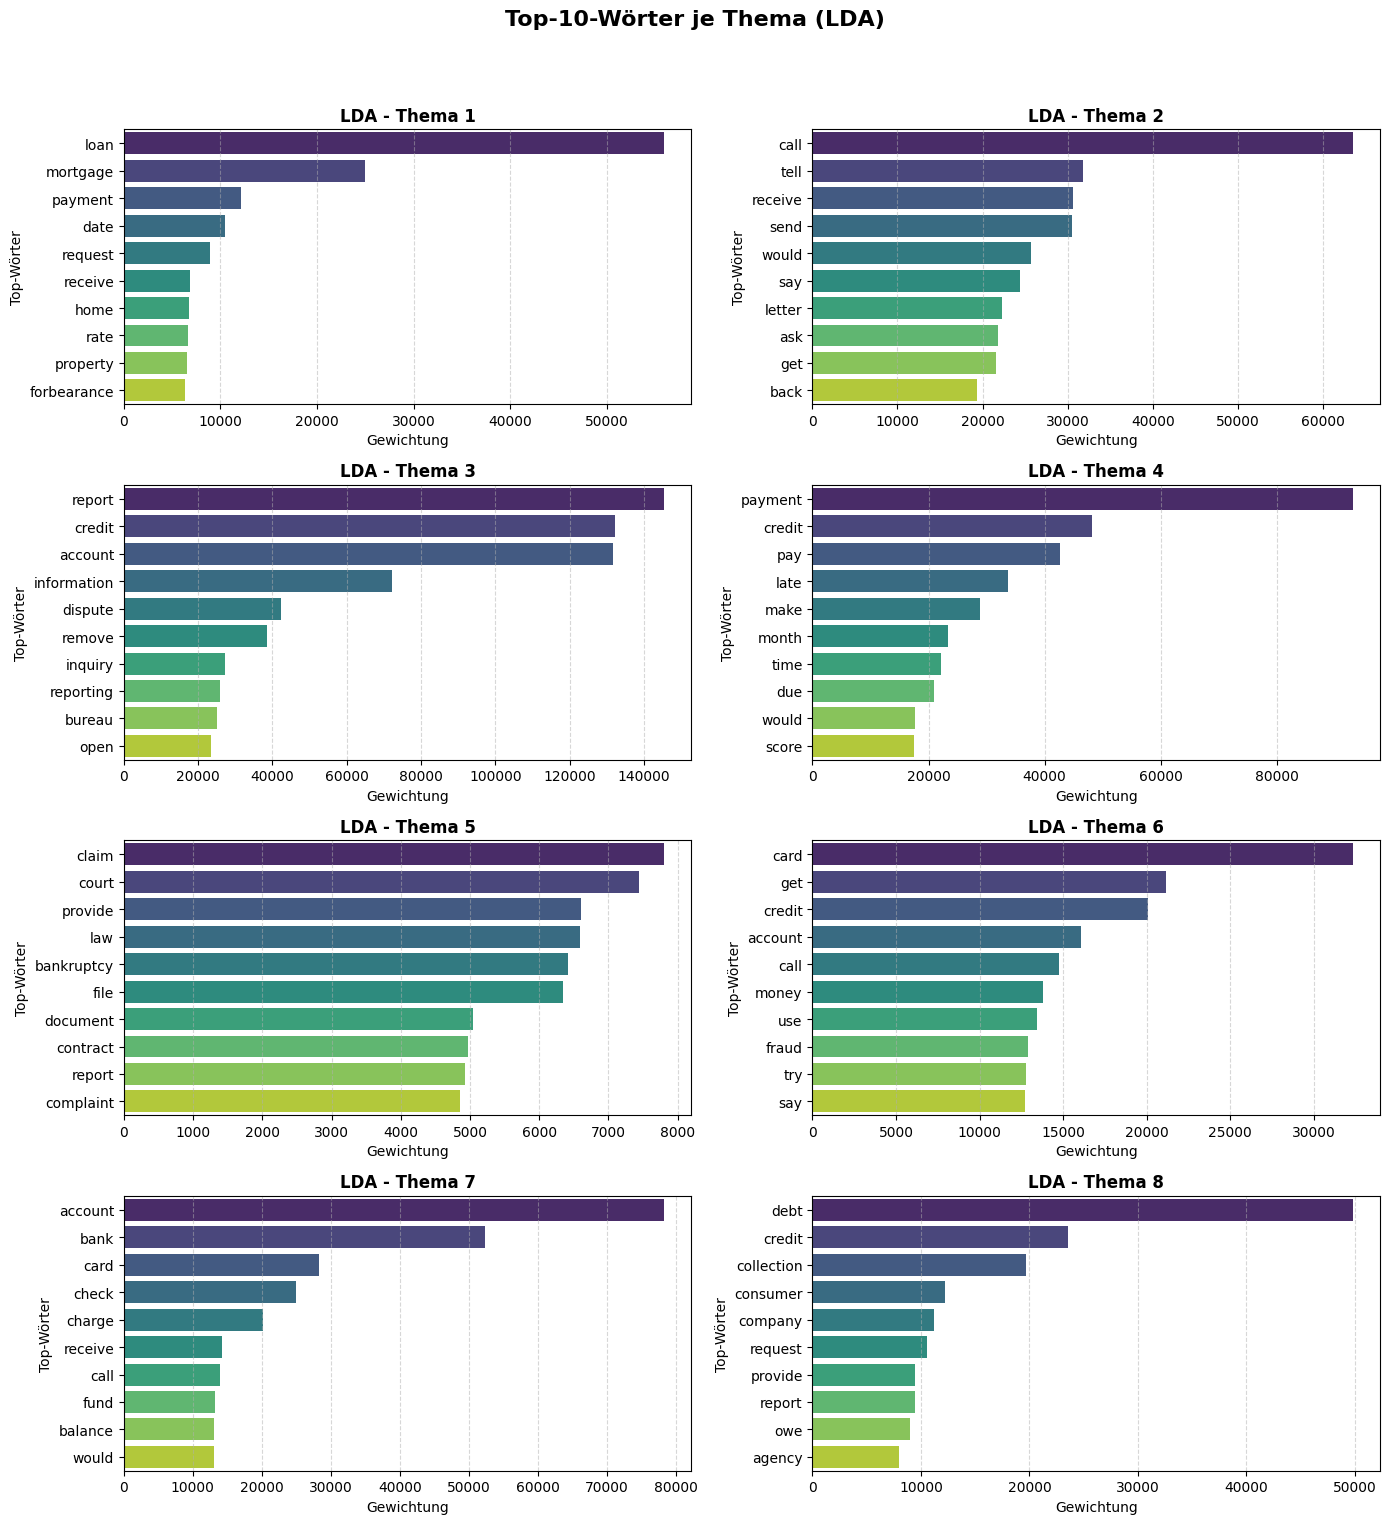

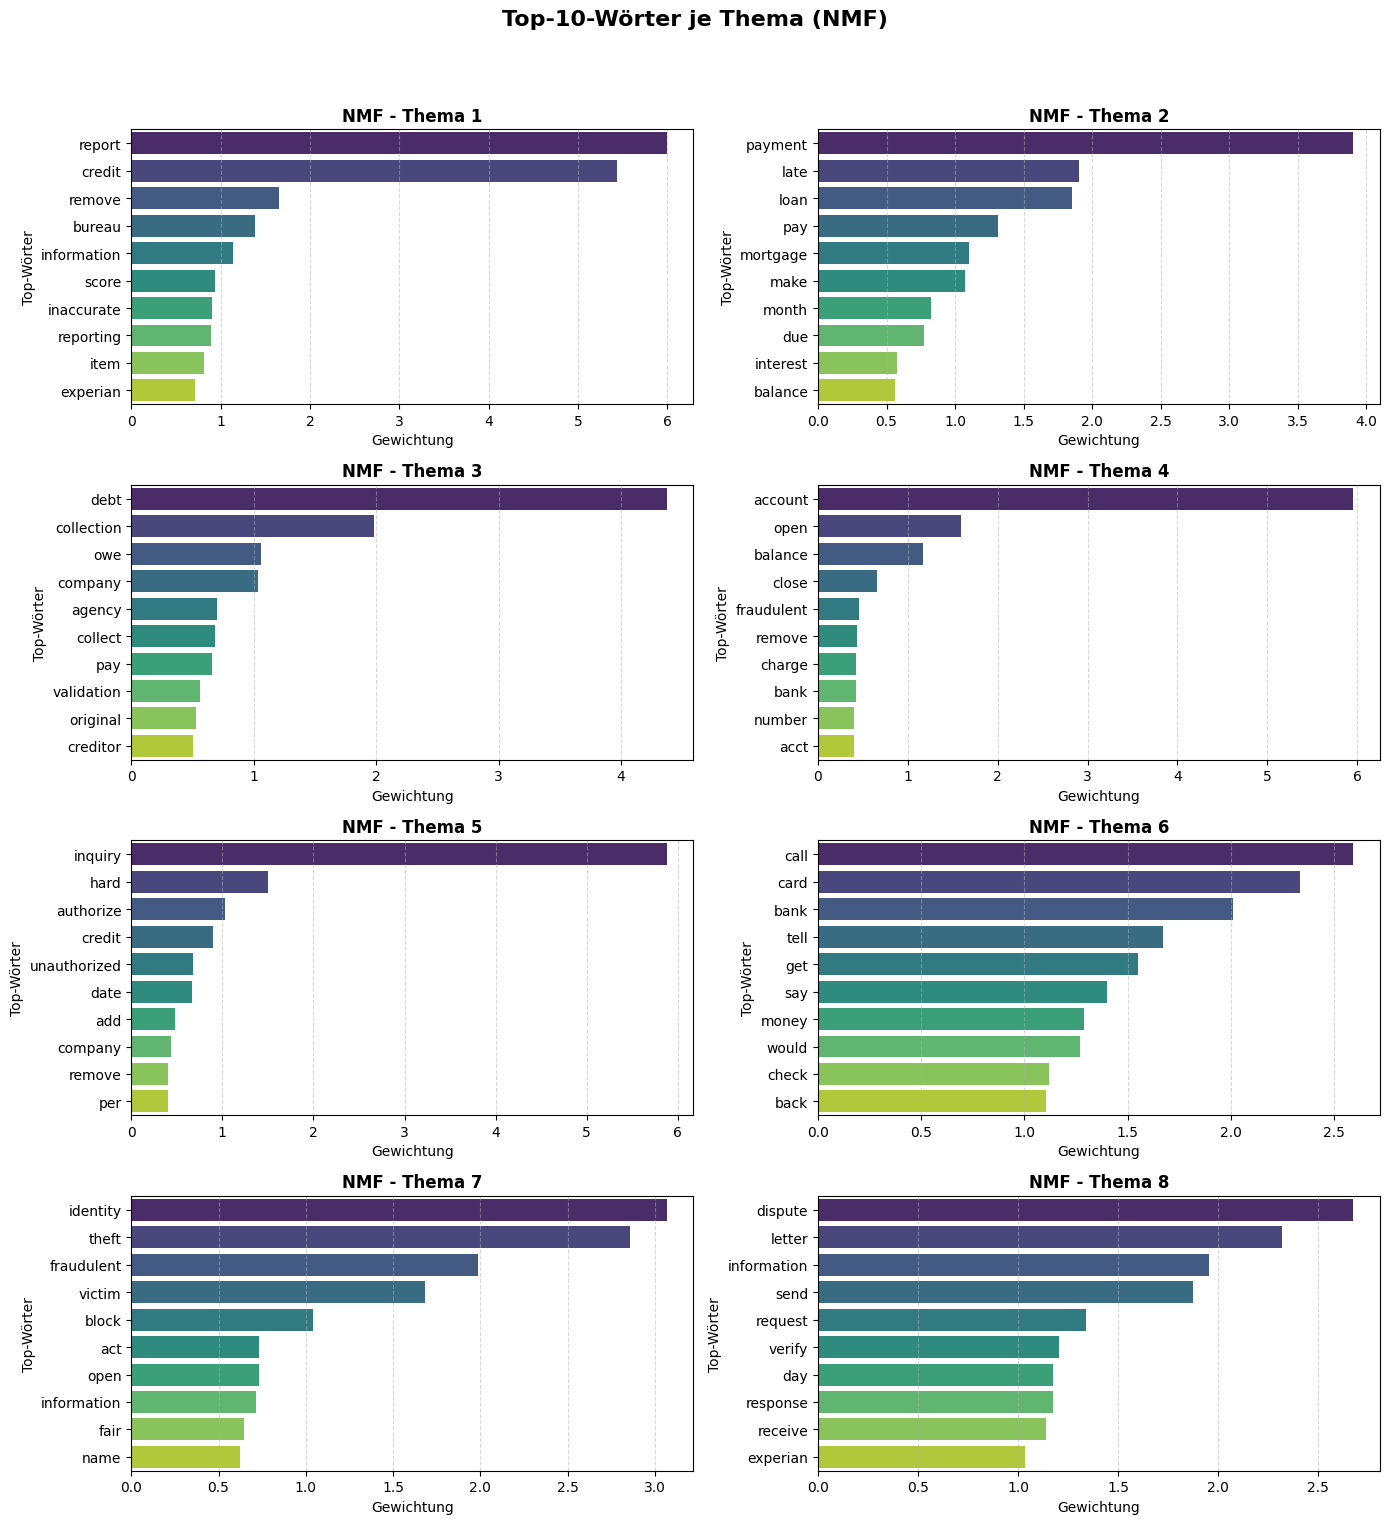

In [54]:
def plot_top_words(model, feature_names, n_top_words=10, title_prefix='LDA'):
    """Zeigt die Top-Wörter pro Thema als strukturierte Balkendiagramme."""
    n_topics = model.n_components
    n_rows = (n_topics + 1) // 2  # 2 Spalten pro Reihe
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 4), sharex=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]

        ax = axes[topic_idx]
        sns.barplot(x=weights, y=top_features, ax=ax, hue=top_features, palette="viridis")
        ax.set_title(f"{title_prefix} - Thema {topic_idx + 1}", fontsize=12, weight='bold')
        ax.set_xlabel("Gewichtung")
        ax.set_ylabel("Top-Wörter")
        ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Entferne leere Subplots
    for j in range(topic_idx + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Top-{n_top_words}-Wörter je Thema ({title_prefix})", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualisierung für beide Modelle
plot_top_words(lda, feature_names=cv.get_feature_names_out(), n_top_words=10, title_prefix='LDA')
plot_top_words(nmf, feature_names=tfidf_vectorizer.get_feature_names_out(), n_top_words=10, title_prefix='NMF')

# 7) Vergleich der Kohärenzwerte (LDA vs. NMF)

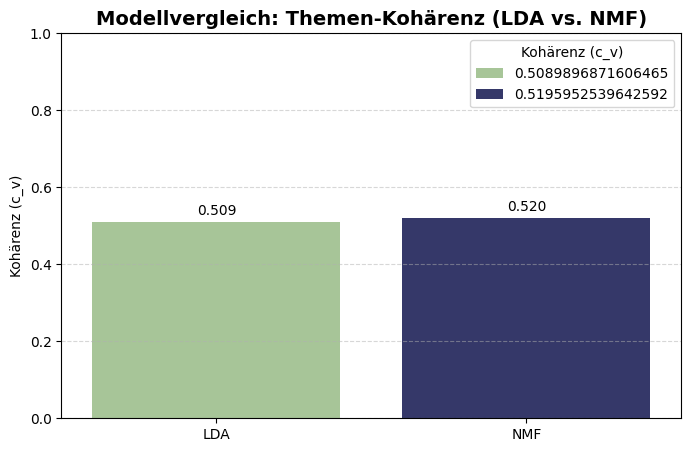

In [55]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Modell', 
    y='Kohärenz (c_v)', 
    data=comparison_df, 
    hue='Kohärenz (c_v)',
    palette='crest'
)
plt.title('Modellvergleich: Themen-Kohärenz (LDA vs. NMF)', fontsize=14, weight='bold')
plt.ylabel('Kohärenz (c_v)')
plt.xlabel('')
plt.ylim(0, 1)
for i, v in enumerate(comparison_df['Kohärenz (c_v)']):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 8) Auswertung der Top-Themen

In [62]:
# Top-Wörter pro Thema (LDA)
n_top_words = 10
topics_summary = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [cv.get_feature_names_out()[i] for i in top_indices]
    topics_summary.append((topic_idx + 1, top_features))

In [57]:
# Optional: Kurze Beschreibung zu jedem Thema
topic_descriptions = {
    1: "Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten",
    2: "Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe",
    3: "Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen",
    4: "Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren",
    5: "Versicherungen, Ansprüche, Zahlungen – Verzögerungen oder Ablehnungen bei Versicherungsleistungen",
    6: "Kundendienst, Kommunikation, Support – Probleme mit Kundenservice und Support",
    7: "Schulden, Inkasso, Rückzahlungen – Beschwerden über Inkassounternehmen oder Schuldenmanagement",
    8: "Sonstige Finanzprodukte – Themen, die in die vorherigen Kategorien nicht passen"
}

# Ausgabe der Beschreibungen zusammen mit Top-Wörtern
for topic_num, words in topics_summary:
    print(f"\n--- Thema {topic_num} ---")
    print("Top-Wörter:", ", ".join(words))
    print("Beschreibung:", topic_descriptions.get(topic_num, "Keine Beschreibung verfügbar"))



--- Thema 1 ---
Top-Wörter: loan, mortgage, payment, date, request, receive, home, rate, property, forbearance
Beschreibung: Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten

--- Thema 2 ---
Top-Wörter: call, tell, receive, send, would, say, letter, ask, get, back
Beschreibung: Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe

--- Thema 3 ---
Top-Wörter: report, credit, account, information, dispute, remove, inquiry, reporting, bureau, open
Beschreibung: Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen

--- Thema 4 ---
Top-Wörter: payment, credit, pay, late, make, month, time, due, would, score
Beschreibung: Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren

--- Thema 5 ---
Top-Wörter: claim, court, provide, law, bankruptcy, file, document, contract, report, complaint
Beschreibung: Versicherungen, Ansprüche, Zahlungen – 

# 9) Zusammenfassung der häufigsten Themen

   Thema  Anzahl Beschwerden
0      1                7511
1      2               16036
2      3               37206
3      4               20387
4      5                2747
5      6               16924
6      7               14150
7      8                9512


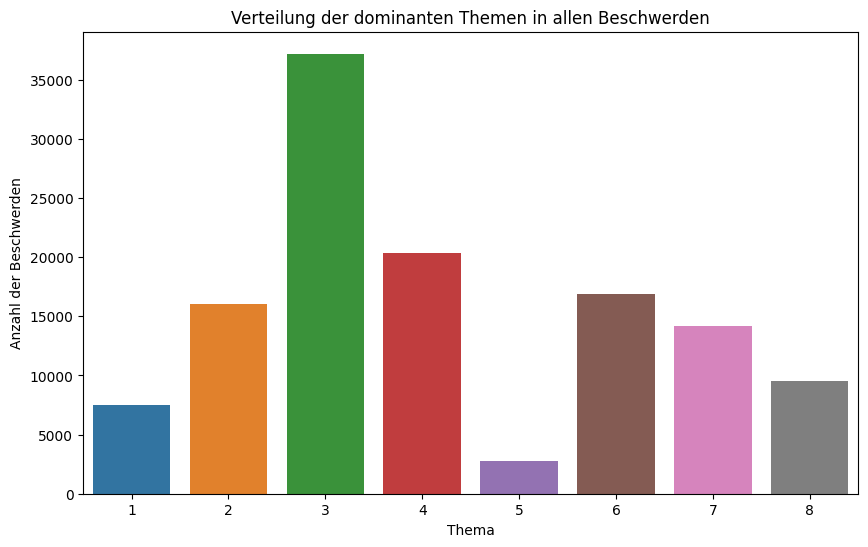

In [58]:
if 'df' in globals() and 'cleaned_text' in df.columns:
    # Dominantes Thema pro Dokument (höchster LDA-Score)
    doc_topic_dist = lda.transform(dtm)
    df['dominant_topic'] = doc_topic_dist.argmax(axis=1) + 1 # +1, um 1-basiert zu sein


    # Zähle Anzahl der Dokumente pro Thema
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    summary_df = pd.DataFrame({
    'Thema': topic_counts.index,
    'Anzahl Beschwerden': topic_counts.values
    })
    print(summary_df)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Thema', y='Anzahl Beschwerden', data=summary_df, 
            hue='Thema', palette='tab10', dodge=False, legend=False)

    plt.title('Verteilung der dominanten Themen in allen Beschwerden')
    plt.xlabel('Thema')
    plt.ylabel('Anzahl der Beschwerden')
    plt.show()

# Diskussion der Ergebnisse

Die Gegenüberstellung zeigt, dass beide Modelle ähnliche Themenfelder erkennen:

- Kreditkarten, Zinsen und Gebühren
- Hypotheken und Rückzahlungen
- Identitätsdiebstahl und Betrugsfälle
- Kundendienst und Kommunikationsprobleme

**Bewertung:**

- Das **LDA-Modell** neigt zu breiteren, überlappenden Themen, was nützlich für explorative Analysen ist.
- Das **NMF-Modell** liefert schärfer getrennte Themencluster und eignet sich daher für eine klarere Kategorisierung der Beschwerden.
- Die Kombination von **TF-IDF + NMF** ergibt tendenziell interpretierbarere Ergebnisse.

**Fazit:**  
Beide semantischen Verfahren ermöglichen es, häufige Beschwerdethemen zu identifizieren.  
Damit entsteht eine fundierte Datengrundlage für strategische Entscheidungen im Verbraucherschutz.

# Schlussfolgerung

Die Analyse der CFPB-Beschwerden zeigt, dass mit Hilfe von NLP-Techniken ein klarer Überblick 
über die dominanten Themenfelder gewonnen werden kann.  

Besonders TF-IDF in Kombination mit NMF liefert interpretierbare Ergebnisse, 
die häufige Verbraucherprobleme wie Zinsfragen, Zahlungsrückstände und Kommunikationsdefizite offenlegen.

Die entwickelte Methodik kann auf ähnliche textbasierte Beschwerde- oder Feedbacksysteme übertragen werden, 
um datengetriebene Entscheidungen im Sinne der Bürger:innen zu unterstützen.